In [1]:
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.hysteresis import *

# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )


from OSCC_postprocessing.analysis.multihole_utils import *
from OSCC_postprocessing.binary_ops.functions_bw import *
from OSCC_postprocessing.filters.video_filters import median_filter_video_auto, sobel_5x5_kernels, filter_video_fft
from OSCC_postprocessing.filters.svd_background_removal import godec_like
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.filters.bilateral_filter import (
    bilateral_filter_video_cpu,
    bilateral_filter_video_cupy,
    bilateral_filter_video_volumetric_chunked_halo,
)
from OSCC_postprocessing.io.async_avi_saver import AsyncAVISaver
import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import binary_fill_holes
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from OSCC_postprocessing.binary_ops.functions_bw import _triangle_threshold_from_hist, _boundary_points_one_frame
from OSCC_postprocessing.analysis.multihole_utils import triangle_binarize_gpu as _triangle_binarize_gpu
from OSCC_postprocessing.filters.bilateral_filter import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

# Selecting image rotation solver based on available hardware
if use_gpu:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    rotate_video_nozzle_at_0_half_backend = rotate_video_nozzle_at_0_half_numpy

from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json
from OSCC_postprocessing.binary_ops.masking import *
from OSCC_postprocessing.filters.convolution_2D_rawKernel import *
from OSCC_postprocessing.analysis.hysteresis import * 
from OSCC_postprocessing.filters.bilateral_filter_rawKernel import *
from OSCC_postprocessing.analysis.penetration_cdf import penetration_cdf_front, monotone_non_decreasing

def _as_numpy(arr):
    if USING_CUPY and hasattr(arr, "__cuda_array_interface__"):
        return cp.asnumpy(arr)
    return np.asarray(arr)

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Py\\Mie_Postprocessing_Py\\.venv311\\Lib\\site-packages\\cupy\\__init__.py'>


In [2]:
# Nozzle 4
file = Path(r"G:\OSCC\LubeOil\BC20241007_HZ_Nozzle4\cine\T9\T9(3).cine")
json_file = Path(r"G:\OSCC\LubeOil\BC20241007_HZ_Nozzle4\cine\T9\config.json")

In [3]:
# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits
gamma = 1.0

frames_before_SOI = 10

tp_num = int(file.parts[-2].replace("T", ""))

if tp_num == 1 or tp_num == 10 or tp_num == 19:
    frame_limit = 80
else:
    frame_limit = 50 

# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file, frame_limit=frame_limit)
# Normalize the grayscale video to [0, 1] brightness range
video = xp.asarray(video)/ brightness_levels





F, H, W = video.shape

# Json file contains the metadata
with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    # offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)



print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")

Video Info - Width: 768, Height: 768, Frames: 50
The injector has 10 plumes.
The nozzle is centred at (392.96, 379.92) in image coordinates.


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_spray_image(img):
    # 1. 读取图像
    # 注意：读取为灰度图
    # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # 归一化到 0-1 浮点数，避免计算溢出
    img_float = img.astype(np.float32) / 255.0

    # 2. 设置 DoG 参数
    # 对于喷雾，sigma 需要略大以平滑散斑噪声
    # sigma1: 内部尺度 (保留细节)
    # sigma2: 外部尺度 (抑制背景)
    # 经验值：sigma2 = 1.6 * sigma1 (Marr-Hildreth 建议)
    # 针对您的图，喷雾较粗，建议 sigma1=2.0, sigma2=3.2 甚至更大
    sigma1 = 2.0
    sigma2 = 3.2
    
    g1 = cv2.GaussianBlur(img_float, (0, 0), sigma1)
    g2 = cv2.GaussianBlur(img_float, (0, 0), sigma2)
    
    # DoG 算子
    dog = g1 - g2
    
    # 3. 零交叉检测 (Zero-Crossing)
    # 逻辑：寻找正负交界处。
    # 方法：将 DoG 结果二值化（大于0为1，小于0为0），然后提取这个二值掩膜的边界。
    
    # 生成二值掩膜：DoG > 0 的区域通常对应“亮物体”内部
    # 这是一个非常鲁棒的分割，比单纯的亮度阈值更稳定
    binary_mask = np.where(dog > 0, 255, 0).astype(np.uint8)
    
    # 4. 提取边缘 (形态学梯度)
    # 在二值掩膜上做边缘提取，得到的即是零交叉线
    kernel = np.ones((3,3), np.uint8)
    edges = cv2.morphologyEx(binary_mask, cv2.MORPH_GRADIENT, kernel)
    
    # --- 可视化对比 ---
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title(f'DoG Response\n($\sigma_1={sigma1}, \sigma_2={sigma2}$)')
    # 显示 DoG 原始值，便于观察正负分布
    plt.imshow(dog, cmap='jet') 
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Zero-Crossing Edges')
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    return edges

# 使用示例 (请替换为您的文件路径)
# edges = process_spray_image('spray.jpg')

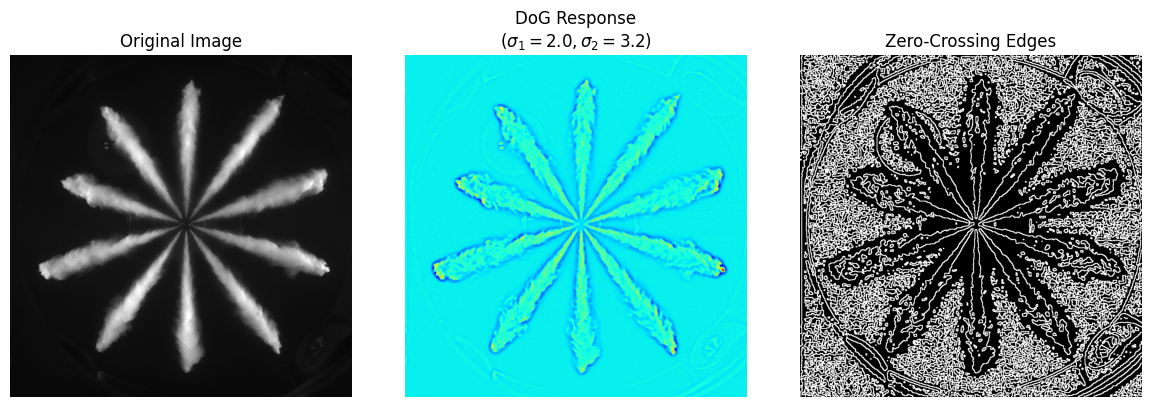

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0, 255, 255, ..., 255, 255, 255],
       [  0, 255, 255, ...,   0,   0,   0],
       [  0, 255, 255, ...,   0,   0,   0]], shape=(768, 768), dtype=uint8)

In [5]:
process_spray_image(video[30].get())

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def optimized_dog_spray(img, sigma1=2.0, sigma2=3.2, threshold_value = 0.02 ):
    # 1. 读取与预处理
    # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_float = img.astype(np.float32) / 255.0

    # 2. DoG 计算 (保持你现在的参数，效果很好)
    g1 = cv2.GaussianBlur(img_float, (0, 0), sigma1)
    g2 = cv2.GaussianBlur(img_float, (0, 0), sigma2)
    dog = g1 - g2

    # 3. 改进点：使用阈值代替零交叉
    # 观察你的中间图，背景是平的，喷雾很亮。
    # 我们设置一个小的正阈值，过滤掉背景噪音（那个圆环）
    # 0.02 是一个经验值，你可以根据实际直方图微调，通常 0.01~0.05 之间
    
    
    # 生成二值掩膜：只保留强响应区域
    # 这一步直接去掉了背景圆环和极微弱的噪声
    mask = (dog > threshold_value).astype(np.uint8) * 255

    # 4. 改进点：形态学闭运算 (Closing)
    # 目的：填充喷雾内部因为纹理产生的细小黑洞，使喷雾变成实心块
    # 结构元素大小决定了能填补多大的洞
    kernel_size = 5 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # 5. 提取最终轮廓
    # 方法A：直接取形态学梯度 (外轮廓)
    final_edges = cv2.morphologyEx(mask_closed, cv2.MORPH_GRADIENT, kernel)
    
    # 方法B (可选)：如果你需要单像素精度的线，可以用 Canny 或 findContours
    # contours, _ = cv2.findContours(mask_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # final_edges_contours = np.zeros_like(mask_closed)
    # cv2.drawContours(final_edges_contours, contours, -1, 255, 1)

    # --- 可视化 ---
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.title('DoG Response')
    plt.imshow(dog, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f'Threshold > {threshold_value} (Mask)')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Final Clean Edges (Morphology)')
    plt.imshow(final_edges, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return final_edges

# 运行
# edges = optimized_dog_spray('your_spray_image.jpg')

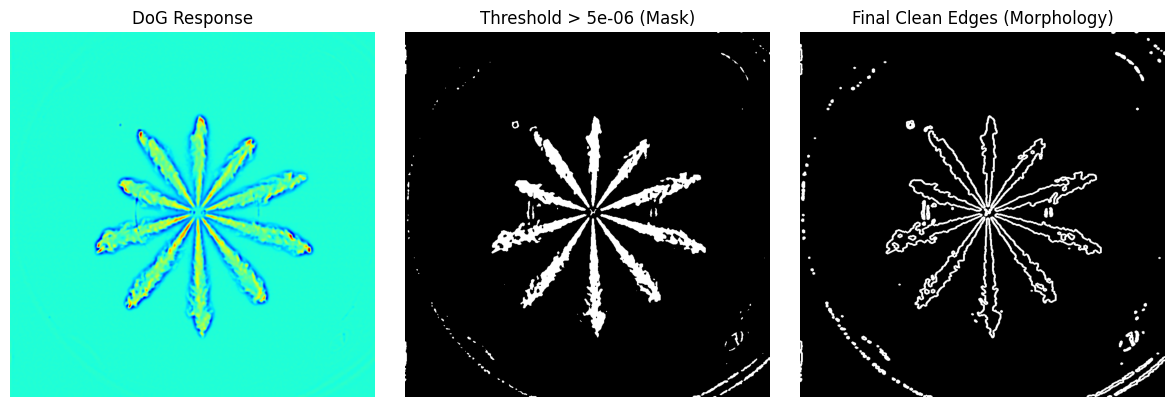

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(768, 768), dtype=uint8)

In [7]:
optimized_dog_spray((video[25]-video[0]).get(),threshold_value = 5e-6)